<a href="https://colab.research.google.com/github/MuhammedAshraf2020/Pneumonia-Diagnosis-/blob/main/Chest_X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Chest-X ray Data from Kaggle

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/chest-xray-pneumonia.zip /content/

In [ ]:
!unzip /content/chest-xray-pneumonia.zip

## Visualize Sample of the data 

In [4]:
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
import torch
import os

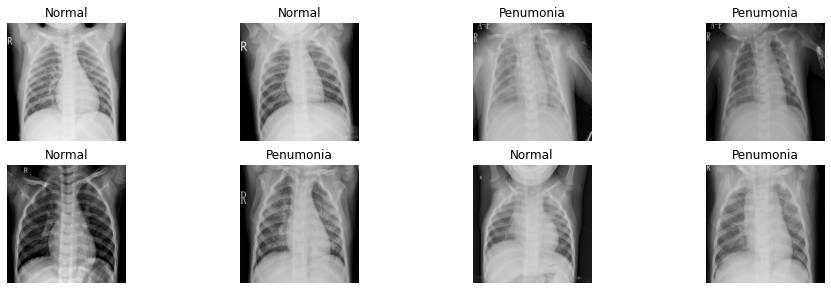

In [5]:
label_dict = {0 : "Normal" , 1 : "Penumonia"}
transform   = transforms.Compose([
                    transforms.Resize((244 , 244)) ,
                    transforms.ToTensor()])

norm_sample = datasets.ImageFolder(root = "/content/chest_xray/val" , transform = transform)
loader  = DataLoader(norm_sample, batch_size = 16 , shuffle=True)

real_batch , labeld = next(iter(loader))
plt.figure(figsize = (16 , 10))
for n , i in enumerate(range(8)):
    plt.subplot(4 , 4 , n +1)
    plt.imshow(np.transpose(real_batch[i] , (1 , 2 , 0)))
    plt.axis("off")
    plt.title(label_dict[labeld[i].item()])

## Build Simple model

In [6]:
from keras.models import Model , Sequential
from keras.layers import Input , BatchNormalization , Dense , LeakyReLU , MaxPooling2D
from keras.layers import Conv2D , Flatten , GlobalAveragePooling2D , Dropout , ReLU , InputLayer

def addLayer(model , filter , kernel):
  model.add(Conv2D(filter , kernel , padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))

def addBlock(model , num_filters):
  addLayer(model , num_filters // 2 , 1)
  addLayer(model , num_filters , 3)
  model.add(MaxPooling2D())


model = Sequential()

model.add(InputLayer(input_shape = (224 , 224 , 3)))
addLayer(model , 16 , 7)
model.add(MaxPooling2D())

addBlock(model , 32)
addBlock(model , 64)
addBlock(model , 128)
addBlock(model , 256)

model.add(GlobalAveragePooling2D())
model.add(Dense(1 , "sigmoid"))

model.compile(optimizer = "adam" , loss = "binary_crossentropy" , metrics = ["accuracy"] )


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      2368      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 112, 112, 16)     

In [7]:
import keras
from keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

test_datagen  = ImageDataGenerator(rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory("/content/chest_xray/train" , 
                                                    class_mode  = "binary" ,
                                                    batch_size  = 16 ,
                                                    target_size = (224 , 224))

val_generator   = test_datagen.flow_from_directory("/content/chest_xray/val" ,                                           
                                                    class_mode  = "binary" ,
                                                    batch_size  = 16 ,
                                                   target_size = (224 , 224))

test_generator  = test_datagen.flow_from_directory("/content/chest_xray/test" ,                                                 
                                                   class_mode  = "binary" ,
                                                    batch_size  = 16 ,
                                                   target_size = (224 , 224),
                                                   shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [35]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
cw = dict(enumerate(weights))
print(cw)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [12]:
from keras.callbacks import ReduceLROnPlateau , EarlyStopping
import numpy as np

callback  = [ReduceLROnPlateau(monitor="val_loss" , patience = 2, verbose=1,factor=0.3, min_lr=0.000001)]
callback += [EarlyStopping(patience = 6)]

In [13]:
hist = hist2 = model.fit(train_generator , validation_data = val_generator , epochs = 25 , callbacks = callback )

Epoch 1/25
326/326 [==============================] - 150s 315ms/step - loss: 0.3162 - accuracy: 0.8590 - val_loss: 6.1327 - val_accuracy: 0.5000
Epoch 2/25
326/326 [==============================] - 103s 317ms/step - loss: 0.2112 - accuracy: 0.9120 - val_loss: 3.1741 - val_accuracy: 0.5000
Epoch 3/25
326/326 [==============================] - 104s 319ms/step - loss: 0.1741 - accuracy: 0.9306 - val_loss: 3.6098 - val_accuracy: 0.5000
Epoch 4/25
326/326 [==============================] - 102s 313ms/step - loss: 0.1544 - accuracy: 0.9414 - val_loss: 6.0678 - val_accuracy: 0.5000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/25
326/326 [==============================] - 103s 317ms/step - loss: 0.1366 - accuracy: 0.9462 - val_loss: 0.5585 - val_accuracy: 0.6875
Epoch 6/25
326/326 [==============================] - 103s 316ms/step - loss: 0.1258 - accuracy: 0.9559 - val_loss: 1.5882 - val_accuracy: 0.5625
Epoch 7/25
326/326 [=======================

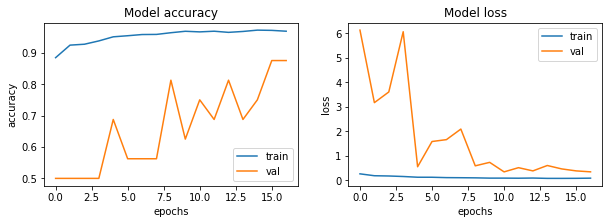

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [15]:
model.evaluate(test_generator)

39/39 [==============================] - 6s 150ms/step - loss: 0.2413 - accuracy: 0.9231


[0.241308331489563, 0.9230769276618958]

In [16]:
from sklearn.metrics import confusion_matrix , classification_report
import matplotlib.pyplot as plt
import seaborn as sn

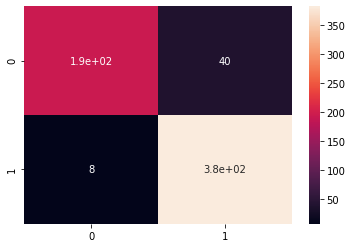

In [22]:
y_pred = np.round(model.predict(test_generator))
cm = confusion_matrix(test_generator.classes, y_pred)

sn.heatmap(cm , annot = True )
plt.show()

In [24]:
target_names = ["Normal" , "Penumonia"]
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.96      0.83      0.89       234
   Penumonia       0.91      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.92       624
weighted avg       0.93      0.92      0.92       624



In [31]:
from keras.models import Model , Sequential
from keras.layers import Input , BatchNormalization , Dense , LeakyReLU , MaxPooling2D
from keras.layers import Conv2D , Flatten , GlobalAveragePooling2D , Dropout , ReLU , InputLayer

def addLayer(model , filter , kernel):
  model.add(Conv2D(filter , kernel , padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))

def addBlock(model , num_filters):
  addLayer(model , num_filters // 2 , 1)
  addLayer(model , num_filters , 3)
  model.add(MaxPooling2D())


model2 = Sequential()

model2.add(InputLayer(input_shape = (224 , 224 , 3)))
addLayer(model2 , 16 , 7)
model2.add(MaxPooling2D())

addBlock(model2 , 32)
addBlock(model2 , 64)
addBlock(model2 , 128)
addBlock(model2 , 256)

model2.add(GlobalAveragePooling2D())
model2.add(Dense(1 , "sigmoid"))

model2.compile(optimizer = "adam" , loss = "binary_crossentropy" , metrics = ["accuracy"] )


In [36]:
hist2 = model2.fit(train_generator , validation_data = val_generator , epochs = 25 , callbacks = callback , class_weight = cw)

Epoch 1/25
326/326 [==============================] - 105s 316ms/step - loss: 0.3691 - accuracy: 0.8453 - val_loss: 2.2701 - val_accuracy: 0.5000
Epoch 2/25
326/326 [==============================] - 103s 316ms/step - loss: 0.2372 - accuracy: 0.9025 - val_loss: 2.5286 - val_accuracy: 0.5000
Epoch 3/25
326/326 [==============================] - 103s 316ms/step - loss: 0.2136 - accuracy: 0.9098 - val_loss: 1.3781 - val_accuracy: 0.4375
Epoch 4/25
326/326 [==============================] - 103s 315ms/step - loss: 0.1842 - accuracy: 0.9298 - val_loss: 1.2958 - val_accuracy: 0.5000
Epoch 5/25
326/326 [==============================] - 101s 309ms/step - loss: 0.1792 - accuracy: 0.9279 - val_loss: 1.4914 - val_accuracy: 0.5000
Epoch 6/25
326/326 [==============================] - 103s 315ms/step - loss: 0.1932 - accuracy: 0.9257 - val_loss: 0.9435 - val_accuracy: 0.5625
Epoch 7/25
326/326 [==============================] - 102s 313ms/step - loss: 0.1695 - accuracy: 0.9317 - val_loss: 1.0968 -

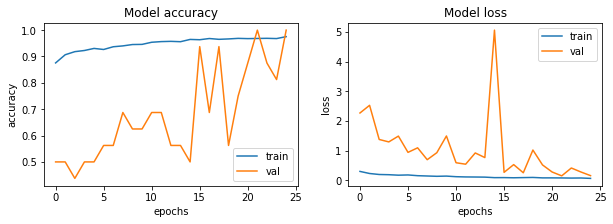

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist2.history[met])
    ax[i].plot(hist2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [38]:
model2.evaluate(test_generator)

39/39 [==============================] - 6s 140ms/step - loss: 0.2084 - accuracy: 0.9359


[0.20844368636608124, 0.9358974099159241]

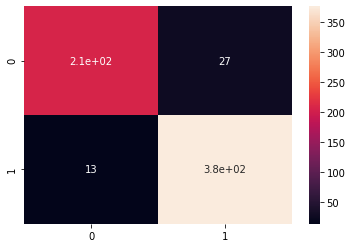

In [39]:
y_pred = np.round(model2.predict(test_generator))
cm = confusion_matrix(test_generator.classes, y_pred)

sn.heatmap(cm , annot = True )
plt.show()

In [40]:
target_names = ["Normal" , "Penumonia"]
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.94      0.88      0.91       234
   Penumonia       0.93      0.97      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.93      0.93       624
weighted avg       0.94      0.94      0.94       624

